## Logistic regression

This notebook contains:
- Code for training logistic regression models to classify texts as being either LLM-generated or human-written.
- Code for calculating and visualizing SHAP values (feature importance) of the best performing model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import shap
from scipy.sparse import load_npz
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
import pickle

In [15]:
train_data_x_sparse = load_npz('../data/train_data_x_sparse.npz')
train_data_x_dense = pd.read_csv('../data/train_data_x_dense.csv')
pretest_data_x_sparse = load_npz('../data/pretest_data_x_sparse.npz')
pretest_data_x_dense = pd.read_csv('../data/pretest_data_x_dense.csv')
test_data_x_sparse = load_npz('../data/test_data_x_sparse.npz')
test_data_x_dense = pd.read_csv('../data/test_data_x_dense.csv')

train_data_x = pd.DataFrame(hstack([train_data_x_sparse, csr_matrix(train_data_x_dense.values)]).toarray())
pretest_data_x = pd.DataFrame(hstack([pretest_data_x_sparse, csr_matrix(pretest_data_x_dense.values)]).toarray())
test_data_x = pd.DataFrame(hstack([test_data_x_sparse, csr_matrix(test_data_x_dense.values)]).toarray())
train_data_y = np.ravel(pd.read_csv('../data/train_data_y.csv'))
pretest_data_y = np.ravel(pd.read_csv('../data/pretest_data_y.csv'))
test_data_y = np.ravel(pd.read_csv('../data/test_data_y.csv'))

with open('../data/sparse_matrices_feature_names.pkl', 'rb') as f:
    sparse_matrices_feature_names = pickle.load(f)

all_feature_names = list(sparse_matrices_feature_names) + list(train_data_x_dense.columns)
dense_feature_indices = [all_feature_names.index(feature) for feature in train_data_x_dense.columns]
dense_feature_names = list(train_data_x_dense.columns) # Engineered features
sparse_feature_indices = [all_feature_names.index(feature) for feature in sparse_matrices_feature_names]
sparse_feature_names = list(sparse_matrices_feature_names) # TF-IDF features

In [16]:
# Standard logistic regression / Regularized - ridge

standard_logreg_model = LogisticRegression(max_iter=500, random_state=28) # Increased max_iter to allow for convergence

standard_logreg_model.fit(train_data_x, train_data_y)


LogisticRegression(max_iter=500, random_state=28)

In [17]:
# Regularized logistic regression (lasso)

lasso_logreg_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=28)

lasso_logreg_model.fit(train_data_x, train_data_y)


LogisticRegression(penalty='l1', random_state=28, solver='liblinear')

In [18]:
# Regularized logistic regression (elastic net)

elastic_net_logreg_model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=500, random_state=28) # Increased max_iter to allow for convergence

elastic_net_logreg_model.fit(train_data_x, train_data_y)


LogisticRegression(l1_ratio=0.5, max_iter=500, penalty='elasticnet',
                   random_state=28, solver='saga')

In [19]:
# F1 scores

standard_logreg_f1_train = f1_score(train_data_y, standard_logreg_model.predict(train_data_x))
lasso_logreg_f1_train = f1_score(train_data_y, lasso_logreg_model.predict(train_data_x))
elastic_net_logreg_f1_train = f1_score(train_data_y, elastic_net_logreg_model.predict(train_data_x))
standard_logreg_f1_pretest = f1_score(pretest_data_y, standard_logreg_model.predict(pretest_data_x))
lasso_logreg_f1_pretest = f1_score(pretest_data_y, lasso_logreg_model.predict(pretest_data_x))
elastic_net_logreg_f1_pretest = f1_score(pretest_data_y, elastic_net_logreg_model.predict(pretest_data_x))
standard_logreg_f1_test = f1_score(test_data_y, standard_logreg_model.predict(test_data_x))
lasso_logreg_f1_test = f1_score(test_data_y, lasso_logreg_model.predict(test_data_x))
elastic_net_logreg_f1_test = f1_score(test_data_y, elastic_net_logreg_model.predict(test_data_x))

# GitHub Copilot used for print statement formatting
print(f"{'':<20s}{'|':<12s}{'LogReg ridge':<23s}{'|':<12s}{'LogReg lasso':<23s}{'|':<8s}{'LogReg elastic net':<27s}|")
print(f"{'-' * 20}{'|'}{'-' * 17}{'+'}{'-' * 16}{'+'}{'-' * 17}{'+'}{'-' * 16}{'+'}{'-' * 17}{'+'}{'-' * 16}{'|'}")
print(f"{'F1 score train':<20s}{'|':<15s}{standard_logreg_f1_train:<20.4f}{'|':<15s}{lasso_logreg_f1_train:<20.4f}{'|':<15s}{elastic_net_logreg_f1_train:<20.4f}|")
print(f"{'F1 score pretest':<20s}{'|':<15s}{standard_logreg_f1_pretest:<20.4f}{'|':<15s}{lasso_logreg_f1_pretest:<20.4f}{'|':<15s}{elastic_net_logreg_f1_pretest:<20.4f}|")
print(f"{'F1 score test':<20s}{'|':<15s}{standard_logreg_f1_test:<20.4f}{'|':<15s}{lasso_logreg_f1_test:<20.4f}{'|':<15s}{elastic_net_logreg_f1_test:<20.4f}|")

                    |           LogReg ridge           |           LogReg lasso           |       LogReg elastic net         |
--------------------|-----------------+----------------+-----------------+----------------+-----------------+----------------|
F1 score train      |              0.9044              |              0.9073              |              0.9057              |
F1 score pretest    |              0.8975              |              0.8991              |              0.8986              |
F1 score test       |              0.8644              |              0.8732              |              0.8674              |


In [20]:
# Samples used for calculating SHAP values

shap_samples = shap.sample(test_data_x, 100, random_state=28)
dense_shap_samples = shap_samples.iloc[:, dense_feature_indices]
sparse_shap_samples = shap_samples.iloc[:, sparse_feature_indices]


In [21]:
# SHAP explenations for the best performing model - Regularized logistic regression (lasso)

explainer = shap.KernelExplainer(standard_logreg_model.predict, shap_samples)

shap_values = explainer.shap_values(shap_samples, num_workers=8)
dense_shap_values = shap_values[:, dense_feature_indices]
sparse_shap_values = shap_values[:, sparse_feature_indices]

  0%|          | 0/100 [00:00<?, ?it/s]

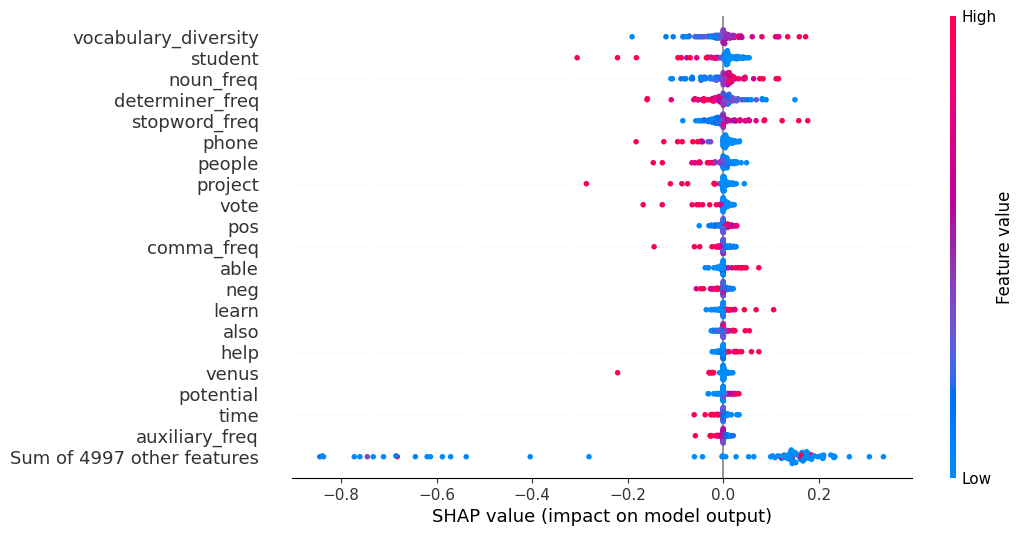

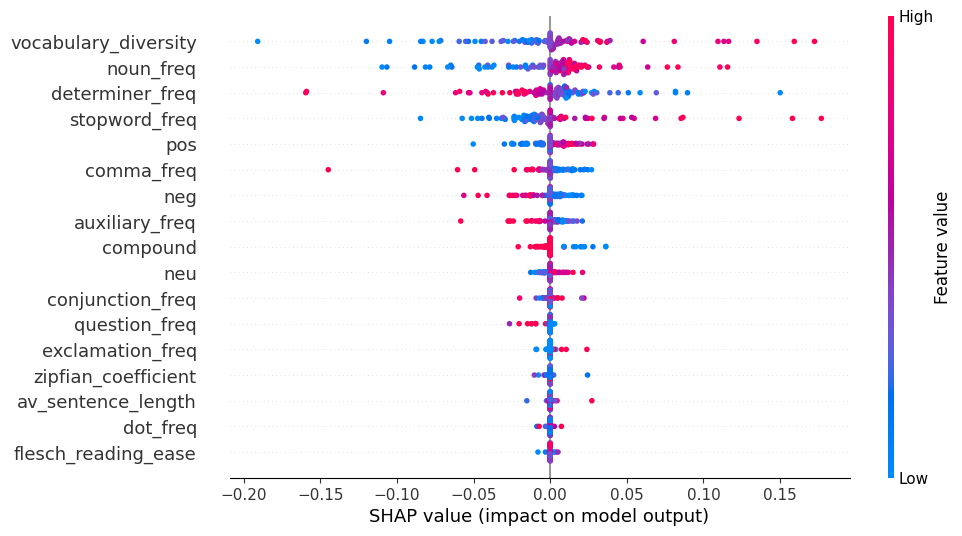

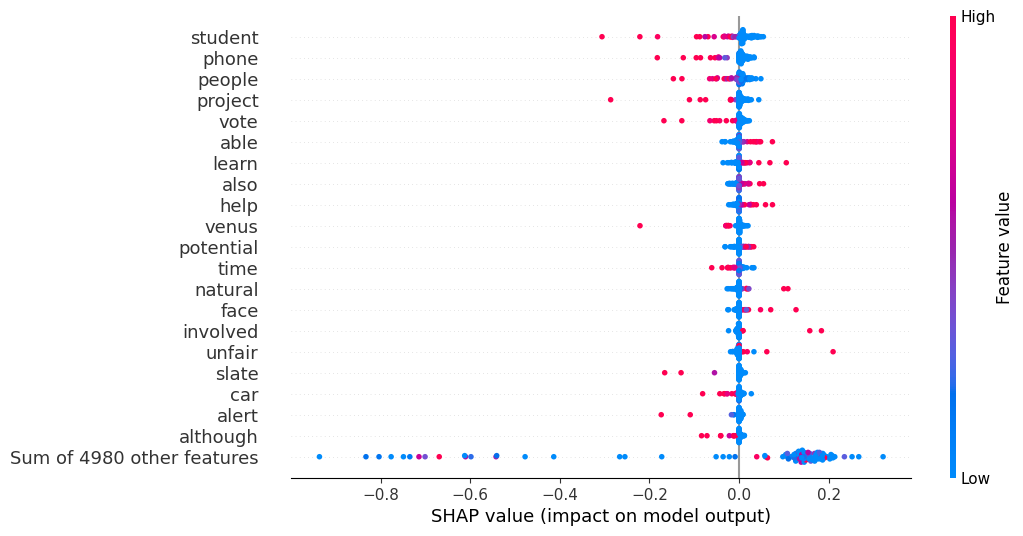

In [23]:
# Visualizing feature importance through beeswarm plots

shap.plots.beeswarm(
    shap.Explanation(values=shap_values, data=shap_samples, feature_names=all_feature_names),
    max_display=21,
    plot_size=(10, 6)
)

shap.plots.beeswarm(
    shap.Explanation(values=dense_shap_values, data=dense_shap_samples, feature_names=dense_feature_names),
    max_display=21,
    plot_size=(10, 6)
)

shap.plots.beeswarm(
    shap.Explanation(values=sparse_shap_values, data=sparse_shap_samples, feature_names=sparse_feature_names),
    max_display=21,
    plot_size=(10, 6)
)